In [34]:
from CoraData import *
from CiteseerData import CiteseerData
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.init as init
import torch
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score
import os

In [35]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [36]:
# 设置随机数种子
def init_seeds(seed=3407):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # 确保每次运行时计算结果一致
    torch.backends.cudnn.benchmark = False # 禁用cudnn的自动寻找最适合当前配置的算法功能，从而确保结果的一致性

## load_data

In [37]:
init_seeds()
# 读取数据
dataset_name = 'cora'
path_of_cora = "cora/cora"
path_of_citeseer = "citeseer/citeseer"

dataset = None
if dataset_name == "cora":
    dataset = CoraData(path_of_cora)
elif dataset_name == "citeseer":
    dataset = CiteseerData(path_of_citeseer)
    
num_nodes = dataset.num_nodes
edge_index = dataset.edge_of_pg
num_of_class = dataset.num_of_class
feature_dim = dataset.feature_dim
# 点集分割
train_mask, val_mask, test_mask = dataset.data_partition_node()
# 边集分割
train_pos_edge_index, validate_pos_edge_index, test_pos_edge_index, train_neg_edge_index, \
validate_neg_edge_index, test_neg_edge_index = data_partition_edge(dataset.edge_of_pg, num_nodes)


## 网络结构

In [38]:
# 手动搭建的GCN卷积模型
class GraphConvolution(nn.Module):
    def __init__(self, in_features_dim, out_features_dim, use_bias=True):
        # 此部分要计算的是卷积部分D^-1/2 A D^-1/2 * X * W , X为feature，W为参数
        super(GraphConvolution, self).__init__()

        self.in_features_dim = in_features_dim
        self.out_features_dim = out_features_dim
        self.use_bias = use_bias

        # 定义GCN层的 W 权重形状
        self.weight = nn.Parameter(torch.Tensor(in_features_dim, out_features_dim))

        # 定义GCN层的 b 权重矩阵
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(out_features_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    # 声明初始化 nn.Module 类里面的W,b参数
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        # init.xavier_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adj, in_feature):
        # 添加自环操作，将邻接矩阵对角线元素设为1
        adj = adj.to_dense()  # 将稀疏矩阵转换为密集矩阵
        adj = adj + torch.eye(adj.size(0)).to(device)  # 添加自环，对角线元素设为1
        support = torch.mm(in_feature, self.weight)  # X*W
        output = torch.sparse.mm(adj, support)  # A*X*W
        if self.use_bias:
            output += self.bias  # 添加偏置项
        return output


# 节点分类的GCN网络
class NodeClassificationGCN(nn.Module):
    def __init__(self, hidden_layer_dim, num_of_hidden_layer,
                 num_of_class=7, input_feature_dim=1433, dropout=0.01, use_pair_norm=True):
        super(NodeClassificationGCN, self).__init__()
        self.layers = nn.ModuleList()
        # 输入层
        self.layers.append(GraphConvolution(input_feature_dim, hidden_layer_dim))
        # 隐藏层
        for i in range(num_of_hidden_layer-2):
            self.layers.append(GraphConvolution(hidden_layer_dim, hidden_layer_dim))
        # 输出层
        self.layers.append(GraphConvolution(hidden_layer_dim, num_of_class))
        self.dropout = nn.Dropout(p=dropout)
        self.use_pair_norm = use_pair_norm
        self.num_of_hidden_layer = num_of_hidden_layer

    def forward(self, x_feature, adj):
        output = x_feature
        for i, layer in enumerate(self.layers):
            if i != 0:
                output = self.dropout(output)

            output = layer(adj, output)
            if i != (self.num_of_hidden_layer-1):
                output = F.relu(output)
            if self.use_pair_norm:
                output = self.PairNorm(output)

        output = torch.sigmoid(output)
        return output
    
    @staticmethod
    def PairNorm(x_feature):
        mode = 'PN-SI'
        scale = 1
        col_mean = x_feature.mean(dim=0)
        # 通过减去特征列的均值并除以行的平均范数来对特征进行归一化处理
        if mode == 'PN':
            x_feature = x_feature - col_mean
            row_norm_mean = (1e-6 + x_feature.pow(2).sum(dim=1).mean()).sqrt()
            x_feature = scale * x_feature / row_norm_mean
        # 在PN的基础上引入了个体缩放，即每个特征行都有自己的缩放因子
        if mode == 'PN-SI':
            x_feature = x_feature - col_mean
            row_norm_individual = (1e-6 + x_feature.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x_feature = scale * x_feature / row_norm_individual
        # PN-SCS模式是一种基于通道的归一化方式，先计算每行的范数，然后对每个通道进行独立的缩放
        if mode == 'PN-SCS':
            row_norm_individual = (1e-6 + x_feature.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x_feature = scale * x_feature / row_norm_individual - col_mean

        return x_feature


# 链路链接的网络
class LinkPredictionGCN(nn.Module):
    def __init__(self, hidden_layer_dim, num_of_hidden_layer, out_feature_dim,
                 input_feature_dim=1433, dropout=0.1, use_pair_norm=True):
        super(LinkPredictionGCN, self).__init__()
        self.layers = nn.ModuleList()
        # 输入层
        self.layers.append(GraphConvolution(input_feature_dim, hidden_layer_dim))
        # 隐藏层
        for i in range(num_of_hidden_layer - 1):
            self.layers.append(GraphConvolution(hidden_layer_dim, hidden_layer_dim))
        # 输出层
        self.layers.append(GraphConvolution(hidden_layer_dim, out_feature_dim))
        self.dropout = nn.Dropout(p=dropout)
        self.use_pair_norm = use_pair_norm

    # encode部分将num_node*num_feature的in_feature转变成了num_node*out_feature_dim的矩阵
    def encode(self, in_feature, adj):
        output = in_feature
        for i, layer in enumerate(self.layers):
            if i != 0:
                output = self.dropout(output)
            output = layer(adj, output)
            output = F.relu(output)
            if self.use_pair_norm:
                output = self.PairNorm(output)
        return output

    @staticmethod
    def decode(out_feature, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=0)
        logits = (out_feature[edge_index[:, 0]] * out_feature[edge_index[:, 1]]).sum(dim=-1)
        logits = torch.sigmoid(logits)
        return logits
    
    @staticmethod
    def PairNorm(x_feature):
        mode = 'PN-SI'
        scale = 1
        col_mean = x_feature.mean(dim=0)
        # 通过减去特征列的均值并除以行的平均范数来对特征进行归一化处理
        if mode == 'PN':
            x_feature = x_feature - col_mean
            row_norm_mean = (1e-6 + x_feature.pow(2).sum(dim=1).mean()).sqrt()
            x_feature = scale * x_feature / row_norm_mean
        # 在PN的基础上引入了个体缩放，即每个特征行都有自己的缩放因子
        if mode == 'PN-SI':
            x_feature = x_feature - col_mean
            row_norm_individual = (1e-6 + x_feature.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x_feature = scale * x_feature / row_norm_individual
        # PN-SCS模式是一种基于通道的归一化方式，先计算每行的范数，然后对每个通道进行独立的缩放
        if mode == 'PN-SCS':
            row_norm_individual = (1e-6 + x_feature.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x_feature = scale * x_feature / row_norm_individual - col_mean

        return x_feature

## Train And Test


In [39]:
# 产生tensor_adjacency
def generate_tensor_adjacency_for_classify(edge_index, drop_edge=1.1):
    if drop_edge >= 1.0:
        adj = get_adjacent(edge_of_pg=edge_index, num_graph_node=num_nodes, symmetric_of_edge=True)
    else:
        adj = random_adjacent_sampler(edge_of_pg=edge_index, num_graph_node=num_nodes, symmetric_of_edge=True, drop_edge=drop_edge)

    normalize_adj = normalization(adj, self_link=True)

    # 准备将原来的coo_matrix转化到tensor形式
    index_of_coo_matrix = torch.from_numpy(np.asarray([normalize_adj.row, normalize_adj.col]).astype('int64')).long()

    values_of_index_in_matrix = torch.from_numpy(normalize_adj.data.astype(np.float32))

    # 根据三元组构造稀疏矩阵张量
    tensor_adjacency = torch.sparse.FloatTensor(
        index_of_coo_matrix, values_of_index_in_matrix,
        torch.Size([num_nodes, num_nodes]))
    return tensor_adjacency

# 产生tensor_adjacency
def generate_tensor_adjacency_for_link(edge_index, drop_edge=1.1):
    if drop_edge >= 1.0:
        adj = get_adjacent(edge_of_pg=edge_index, num_graph_node=num_nodes)
    else:
        adj = random_adjacent_sampler(edge_of_pg=edge_index, num_graph_node=num_nodes, drop_edge=drop_edge)

    normalize_adj = normalization(adj)

    # 准备将原来的coo_matrix转化到tensor形式
    index_of_coo_matrix = torch.from_numpy(np.asarray([normalize_adj.row, normalize_adj.col]).astype('int64')).long()

    values_of_index_in_matrix = torch.from_numpy(normalize_adj.data.astype(np.float32))

    # 根据三元组构造稀疏矩阵张量
    tensor_adjacency = torch.sparse.FloatTensor(
        index_of_coo_matrix, values_of_index_in_matrix,
        torch.Size([num_nodes, num_nodes]))
    return tensor_adjacency


def plot_loss_and_acc(loss_history, val_loss_history, val_acc_history):
    fig, axs = plt.subplots(2, 1, figsize=(6, 9))

    # 绘制损失图
    axs[0].plot(range(len(loss_history)), loss_history, label='Train Loss', c=np.array([255, 71, 90]) / 255.)
    axs[0].plot(range(len(val_loss_history)), val_loss_history, label='Val Loss', c=np.array([0, 255, 0]) / 255.)
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Training Loss & Validation Loss')

    # 绘制准确率图
    axs[1].plot(range(len(val_acc_history)), val_acc_history, label='Val Accuracy', c=np.array([79, 179, 255]) / 255.)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].set_title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

### 节点分类

In [40]:
# 训练模型
def train():
    loss_list = []
    val_loss_list = []
    val_acc_history = []
    model.train()

    train_y = tensor_y[train_mask]
    for epoch in range(epoch_num):
        tensor_adjacency = generate_tensor_adjacency_for_classify(edge_index=edge_index, drop_edge=drop_edge).to(device)
        logits = model(tensor_x, tensor_adjacency)
        train_mask_logits = logits[train_mask]
        loss = criterion(train_mask_logits, train_y.long())  # 计算训练集上的损失值
        optimizer.zero_grad()  # 梯度归零
        loss.backward()  # 反向传播计算参数的梯度
        optimizer.step()  # 使用优化方法进行梯度更新

        train_acc = test(train_mask)  # 计算当前模型训练集上的准确率
        val_acc = test(val_mask)  # 计算当前模型在验证集上的准确率

        # 计算验证集上的损失值
        val_mask_logits = logits[val_mask]
        val_loss = criterion(val_mask_logits, tensor_y[val_mask].long())

        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_list.append(loss.item())
        val_loss_list.append(val_loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, ValLoss {:.4f}, TrainAcc {:.4f}, ValAcc {:.4f}".format(epoch, loss.item(), val_loss.item(), train_acc.item(), val_acc.item()))

    return loss_list, val_loss_list, val_acc_history

# 测试模型
def test(mask):
    model.eval() 

    with torch.no_grad():  # 减少显存占用
        tensor_adjacency = generate_tensor_adjacency_for_classify(edge_index=edge_index).to(device)
        logits = model(tensor_x, tensor_adjacency)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1] 
        accuracy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuracy

init_seeds()
# 超参数设置
learning_rate = 0.001
epoch_num = 100
weight_decay = 5e-3
hidden_layer_dim = 512
layer_num = 2
drop_edge = 0.2
use_pair_norm = False

tensor_x = torch.tensor(dataset.feature_of_pg, device=device, dtype=torch.float)
tensor_y = torch.tensor(dataset.label_of_pg, device=device, dtype=torch.float)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)

# 模型定义
model = NodeClassificationGCN(hidden_layer_dim=hidden_layer_dim,
                            num_of_hidden_layer=layer_num, 
                            use_pair_norm=use_pair_norm,
                            num_of_class=num_of_class, 
                            input_feature_dim=feature_dim).to(device)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss,val_loss, val_acc = train()
test_acc = test(test_mask)
print("Test accuarcy: ", test_acc.item())
plot_loss_and_acc(loss, val_loss, val_acc)


Epoch 000: Loss 2.0259, ValLoss 2.0376, TrainAcc 0.2617, ValAcc 0.2546
Epoch 001: Loss 1.8511, ValLoss 1.8798, TrainAcc 0.3972, ValAcc 0.3579
Epoch 002: Loss 1.7369, ValLoss 1.7739, TrainAcc 0.4544, ValAcc 0.4059
Epoch 003: Loss 1.6428, ValLoss 1.6825, TrainAcc 0.4994, ValAcc 0.4428
Epoch 004: Loss 1.5554, ValLoss 1.6097, TrainAcc 0.5400, ValAcc 0.4852
Epoch 005: Loss 1.4905, ValLoss 1.5578, TrainAcc 0.5881, ValAcc 0.5129
Epoch 006: Loss 1.4416, ValLoss 1.5273, TrainAcc 0.6700, ValAcc 0.5609
Epoch 007: Loss 1.4072, ValLoss 1.4907, TrainAcc 0.7278, ValAcc 0.6236
Epoch 008: Loss 1.3700, ValLoss 1.4554, TrainAcc 0.8005, ValAcc 0.6863
Epoch 009: Loss 1.3343, ValLoss 1.4282, TrainAcc 0.8633, ValAcc 0.7491
Epoch 010: Loss 1.3057, ValLoss 1.4044, TrainAcc 0.9052, ValAcc 0.7915
Epoch 011: Loss 1.2779, ValLoss 1.3847, TrainAcc 0.9243, ValAcc 0.8118
Epoch 012: Loss 1.2631, ValLoss 1.3748, TrainAcc 0.9286, ValAcc 0.8284
Epoch 013: Loss 1.2599, ValLoss 1.3736, TrainAcc 0.9384, ValAcc 0.8376
Epoch 

### 链路预测

Epoch 000: Loss 0.8133, TrainAcc 0.5, ValLoss 0.8133, ValAcc 0.5000
Epoch 001: Loss 0.8133, TrainAcc 0.5, ValLoss 0.8133, ValAcc 0.5000
Epoch 002: Loss 0.8133, TrainAcc 0.5, ValLoss 0.8133, ValAcc 0.5000
Epoch 003: Loss 0.8133, TrainAcc 0.4996, ValLoss 0.8133, ValAcc 0.5000
Epoch 004: Loss 0.8133, TrainAcc 0.5028, ValLoss 0.8133, ValAcc 0.5011
Epoch 005: Loss 0.8133, TrainAcc 0.5196, ValLoss 0.8133, ValAcc 0.5144
Epoch 006: Loss 0.8133, TrainAcc 0.6221, ValLoss 0.8133, ValAcc 0.5438
Epoch 007: Loss 0.8132, TrainAcc 0.7074, ValLoss 0.8127, ValAcc 0.6015
Epoch 008: Loss 0.8088, TrainAcc 0.7887, ValLoss 0.7634, ValAcc 0.6891
Epoch 009: Loss 0.7354, TrainAcc 0.7334, ValLoss 0.7340, ValAcc 0.6320
Epoch 010: Loss 0.7225, TrainAcc 0.8329, ValLoss 0.7234, ValAcc 0.7591
Epoch 011: Loss 0.7160, TrainAcc 0.8705, ValLoss 0.7179, ValAcc 0.8461
Epoch 012: Loss 0.7075, TrainAcc 0.8982, ValLoss 0.7010, ValAcc 0.8831
Epoch 013: Loss 0.6973, TrainAcc 0.921, ValLoss 0.6939, ValAcc 0.9152
Epoch 014: Loss 

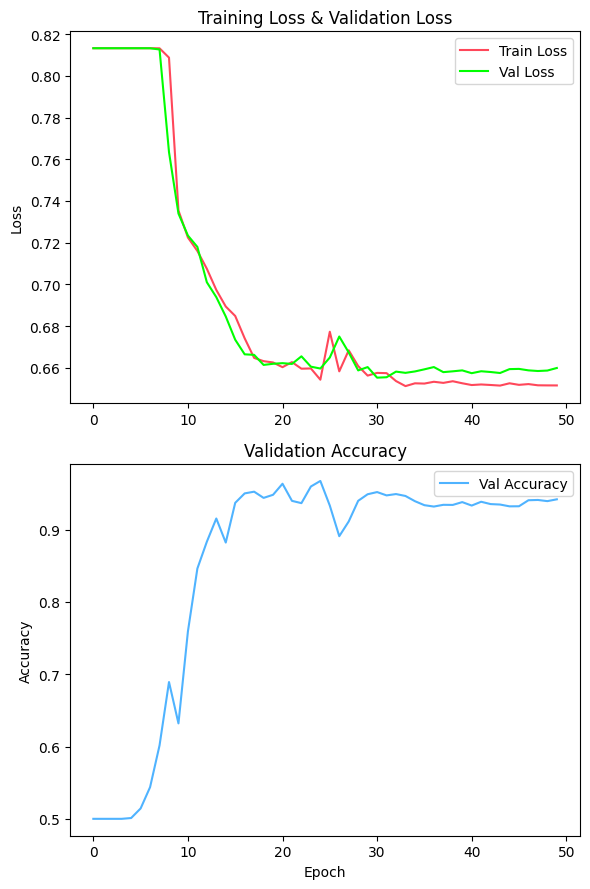

In [41]:
def train():
    loss_list = []
    val_loss_list = []  
    val_acc_history = []
    model.train()

    train_pos_edge_index_cuda = torch.tensor(train_pos_edge_index, device=device, dtype=torch.long)
    validate_pos_edge_index_cuda = torch.tensor(validate_pos_edge_index, device=device, dtype=torch.long)

    for epoch in range(epoch_num):
        tensor_adjacency = generate_tensor_adjacency_for_link(train_pos_edge_index, drop_edge=drop_edge).to(device)
        negative_edge_index = negative_edge_sampling(train_neg_edge_index, train_pos_edge_index)
        negative_edge_index_cuda = torch.tensor(negative_edge_index, device=device, dtype=torch.long)
        out_feature = model.encode(tensor_x, tensor_adjacency)

        logits = model.decode(out_feature, train_pos_edge_index_cuda, negative_edge_index_cuda)
        labels = get_link_labels(train_pos_edge_index_cuda, negative_edge_index_cuda, device=device)
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc = test(train_pos_edge_index, train_neg_edge_index)
        val_acc = test(validate_pos_edge_index, validate_neg_edge_index)

        # 计算验证集loss
        with torch.no_grad():
            val_tensor_adjacency = generate_tensor_adjacency_for_link(validate_pos_edge_index, drop_edge=drop_edge).to(device)
            val_negative_edge_index = negative_edge_sampling(validate_neg_edge_index, validate_pos_edge_index)
            val_negative_edge_index_cuda = torch.tensor(val_negative_edge_index, device=device, dtype=torch.long)
            val_out_feature = model.encode(tensor_x, val_tensor_adjacency)
            val_logits = model.decode(val_out_feature, validate_pos_edge_index_cuda, val_negative_edge_index_cuda)
            val_labels = get_link_labels(validate_pos_edge_index_cuda, val_negative_edge_index_cuda, device=device)
            val_loss = F.binary_cross_entropy_with_logits(val_logits, val_labels)
            val_loss_list.append(val_loss.item())

        loss_list.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValLoss {:.4f}, ValAcc {:.4f}".format(epoch, loss.item(), train_acc.item(),  val_loss.item(), val_acc.item()))

    return loss_list, val_loss_list, val_acc_history


def test(pos_edge_index, neg_edge_index):
    model.eval()  # 表示将模型转变为evaluation（测试）模式，排除BN和Dropout对测试的干扰

    with torch.no_grad():  # 显著减少显存占用
        tensor_adjacency = generate_tensor_adjacency_for_link(train_pos_edge_index).to(device)
        pos_edge_index_cuda = torch.tensor(pos_edge_index, device=device, dtype=torch.long)
        neg_edge_index_cuda = torch.tensor(neg_edge_index, device=device, dtype=torch.long)

        out_feature = model.encode(tensor_x, tensor_adjacency)  # (N,16)->(N,7) N节点数
        logits = model.decode(out_feature, pos_edge_index_cuda, neg_edge_index_cuda)
        labels = get_link_labels(pos_edge_index_cuda, neg_edge_index_cuda, device=device)

        auc = roc_auc_score(labels.cpu(), logits.cpu())
    return auc

init_seeds()
# 超参数设置
learning_rate = 0.01
epoch_num = 50
weight_decay = 5e-4
hidden_layer_dim = 128
out_feature_dim = 64
layer_num = 2
drop_edge = 1.1
use_pair_norm = False


model = LinkPredictionGCN(hidden_layer_dim=hidden_layer_dim, 
                            num_of_hidden_layer=layer_num,
                            out_feature_dim=out_feature_dim, 
                            use_pair_norm=use_pair_norm,
                            input_feature_dim=feature_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

tensor_x = torch.tensor(dataset.feature_of_pg, device=device, dtype=torch.float)

loss, val_loss, val_acc = train()
test_acc = test(test_pos_edge_index, test_neg_edge_index)
print("AUC : ", test_acc.item())
plot_loss_and_acc(loss, val_loss, val_acc)
